# Cluster Configuration + Imports

In [1]:
from dask.distributed import Client

client = Client("tls://192.168.202.90:8786")
client

/usr/local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Connection method: Direct,
Dashboard: /user/noah.alexander.zipper@cern.ch/proxy/8787/status,
Comm: tls://192.168.202.90:8786,Workers: 0
Dashboard: /user/noah.alexander.zipper@cern.ch/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [2]:
import hist
import time
import json
import dask
import numpy as np
import pandas as pd
from functools import reduce
import operator
import numba

import awkward as ak
import dask_awkward as dak
import hist.dask as hda
import vector
vector.register_awkward()

from coffea.nanoevents.methods import candidate, vector
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import coffea.processor as processor
from coffea.dataset_tools import (
    apply_to_fileset,
    max_chunks,
    preprocess,
)

from pprint import pprint
from itertools import combinations, combinations_with_replacement
from collections import defaultdict

/usr/local/lib/python3.10/site-packages/coffea/nanoevents/methods/candidate.py:11: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


# Coffea Histogram Processor

In [14]:
def getFromDict(dataDict, mapList):
    return reduce(operator.getitem, mapList, dataDict)

def has_trigger(res, dataset='JetMET0_slimmed'):
    if 'trigger' in res[dataset]['cutflow'].keys():
        for k in list(res[dataset]['hists'].keys()):
            if ('anomaly_score_L1_' in k) or ('anomaly_score_HLT_' in k):
                return k.split('anomaly_score_')[1]
    else:
        return None


def find_diObjs(events_obj_coll, isL1):
    if isL1:
        rest_mass_dict = {'L1Jet':0, 'L1Mu':0, 'L1EG':0}
        objs = ak.zip(
            {
                "pt": events_obj_coll.pt,
                "eta": events_obj_coll.eta,
                "phi": events_obj_coll.phi,
                "mass": ak.zeros_like(events_obj_coll.pt),
            },
            with_name="PtEtaPhiMLorentzVector",
            behavior=candidate.behavior,
        )
        
        diObjs = dak.combinations(objs, 2, fields=["obj1", "obj2"])
        diObj = ak.zip(
            {
                "p4": diObjs.obj1+diObjs.obj2,
            },
        )
        
        diObj["mass"] = np.sqrt(2*diObjs.obj1.pt*diObjs.obj2.pt*(np.cosh(diObjs.obj1.eta-diObjs.obj2.eta)-np.cos(diObjs.obj1.phi-diObjs.obj2.phi)))

    else:
        objs = ak.zip({ 
            k: getattr(events_obj_coll, k) for k in ["x", "y", "z", "t"] }, 
            with_name="LorentzVector", 
            behavior=events_obj_coll.behavior, 
        )

        diObj = dak.combinations(objs, 2, fields=["obj1", "obj2"])
        diObj["p4"] = diObj.obj1 + diObj.obj2
        diObj["mass"] = diObj.p4.mass

    return diObj

    
class MakeAXOHists (processor.ProcessorABC):
    def __init__(self, trigger_path='', extra_cut='', thresholds=None, object_dict=None):
        self.run_dict = {
            'thresholds' : thresholds if thresholds is not None else {
                'AXOVTight_EMU'  : {'name'  : 'AXO VTight', 'score' : 25000/16},
                'AXOTight_EMU'   : {'name'  : 'AXO Tight', 'score' : 20486/16},
                'AXONominal_EMU' : {'name'  : 'AXO Nominal', 'score' : 18580/16},
                'AXOLoose_EMU'   : {'name'  : 'AXO Loose', 'score' : 17596/16},
                'AXOVLoose_EMU'  : {'name'  : 'AXO VLoose', 'score' : 15717/16},
            },
            'objects' : object_dict if object_dict is not None else {
                        'Jet' :      {'cut' : [('pt', 1000.)], 'label' : 'j'},
                        'Electron' : {'cut' : [('pt', 10)], 'label' : 'e'},
                        'Muon' :     {'cut' : [('pt', 10)], 'label' : '\mu'},
                        'L1Jet' :    {'cut' : [('pt', 1000.)], 'label' : 'L1j'},
                        'L1EG' :     {'cut' : [('pt', 0.1)], 'label' : 'L1e'},
                        'L1Mu' :     {'cut' : [('pt', 0.1)], 'label' : 'L1\mu'},
                       }
        }

        self.sorted_keys = sorted(self.run_dict['thresholds'],key=lambda i: self.run_dict['thresholds'][i]['score'])
        self.trigger_path = trigger_path
        self.extra_cut = extra_cut
        
        self.dataset_axis = hist.axis.StrCategory([], growth=True, name="dataset", label="Primary dataset")
        self.score_axis = hist.axis.Regular(100, 0, 4000, name="score", label='Anomaly Score')
        self.mult_axis = hist.axis.Regular(30,0,30, name="mult", label=r'$n_{obj}$')
        self.pt_axis = hist.axis.Regular(200,0,500, name="pt", label=r"$p_{T}$ [GeV]")
        self.eta_axis = hist.axis.Regular(150,-5,5, name="eta", label=r"$\eta$")
        self.phi_axis = hist.axis.Regular(30,-4,4, name="phi", label=r"$\phi$")
        self.met_axis = hist.axis.Regular(100,0,1000, name="met", label=r"$p^{miss}_{T} [GeV]$")
        self.ht_axis = hist.axis.Regular(100,0,2000, name="ht", label=r"$H_{T}$ [GeV]")
        self.minv_axis = hist.axis.Regular(600,0,3000, name="minv", label=r"$m_{obj_{1},obj_{2}}$ [GeV]")

    def process(self, events):
        dataset = events.metadata['dataset']
        cutflow = defaultdict(int)
        cutflow['start'] = ak.num(events.event, axis=0)
        hist_dict = {}
        
        # Get scalar branches
        axo = events.axol1tl
        l1_etsums = events.L1EtSum
        l1_ht = l1_etsums[l1_etsums.etSumType==1]
        l1_met = l1_etsums[l1_etsums.etSumType==2]
        
        # Fill 1D scalar histograms
        h_score = hda.hist.Hist(self.dataset_axis, self.score_axis, storage="weight", label="nEvents")
        h_score.fill(dataset=dataset, score=axo.score_bx0)
        hist_dict['anomaly_score'] = h_score

        h_score = hda.hist.Hist(self.dataset_axis, self.score_axis, storage="weight", label="nEvents")
        h_score.fill(dataset=dataset, score=axo.score_bx0_unpf)
        hist_dict[f'anomaly_score_unpf'] = h_score
        
        h_score = hda.hist.Hist(self.dataset_axis, self.score_axis, storage="weight", label="nEvents")
        h_score.fill(dataset=dataset, score=axo.score_bx0_unpf_firstbx)
        hist_dict[f'anomaly_score_unpf_firstbx'] = h_score
        
        h_l1ht = hda.hist.Hist(self.dataset_axis, self.ht_axis, storage="weight", label="nEvents")
        h_l1ht.fill(dataset=dataset, ht=ak.flatten(l1_ht.pt))
        hist_dict['l1ht'] = h_l1ht                              

        h_l1met = hda.hist.Hist(self.dataset_axis, self.met_axis, storage="weight", label="nEvents")
        h_l1met.fill(dataset=dataset, met=ak.flatten(l1_met.pt))
        hist_dict['l1met'] = h_l1met

        # Fill 2D scalar histograms
        h_score_l1ht = hda.hist.Hist(self.dataset_axis, self.score_axis, self.ht_axis, storage="weight", label="nEvents")
        h_score_l1ht.fill(dataset=dataset, score=dak.flatten(ak.broadcast_arrays(axo.score_bx0,l1_ht.pt)[0]), ht=ak.flatten(l1_ht.pt))
        hist_dict['anomaly_score_l1ht'] = h_score_l1ht                              

        h_score_l1met = hda.hist.Hist(self.dataset_axis, self.score_axis, self.met_axis, storage="weight", label="nEvents")
        h_score_l1met.fill(dataset=dataset, score=dak.flatten(ak.broadcast_arrays(axo.score_bx0,l1_met.pt)[0]), met=ak.flatten(l1_met.pt))
        hist_dict['anomaly_score_l1met'] = h_score_l1met

        # Process object collections
        for obj,obj_dict in self.run_dict['objects'].items():
            cut_list = obj_dict['cut']
            label = obj_dict['label']
            isL1Obj = 'L1' in obj
            br = getattr(events, obj)

            # Filter only L1 Objects from BX==0
            if isL1Obj:
                br = br[br.bx==0]

            # Apply list of cuts to relevant branches
            for var, cut in cut_list:
                mask = (getattr(br,var) < cut)
                br = br[mask]        
            
            # Build di-object candidate
            objs = br[ak.argsort(br.pt, axis=1)]
            diObj = find_diObjs(objs, isL1Obj)
            
            # Fill 1D histograms
            h_mult = hda.hist.Hist(self.dataset_axis, self.mult_axis, storage="weight", label="nEvents")
            h_mult.fill(dataset=dataset, mult=dak.num(br,axis=1))
            hist_dict[f'n_{obj}'] = h_mult

            h_pt = hda.hist.Hist(self.dataset_axis, self.pt_axis, storage="weight", label="nEvents")
            h_pt.fill(dataset=dataset, pt=dak.flatten(br.pt))
            hist_dict[f'pt_{obj}'] = h_pt

            h_eta = hda.hist.Hist(self.dataset_axis, self.eta_axis, storage="weight", label="nEvents")
            h_eta.fill(dataset=dataset, eta=dak.flatten(br.eta))
            hist_dict[f'eta_{obj}'] = h_eta

            h_phi = hda.hist.Hist(self.dataset_axis, self.phi_axis, storage="weight", label="nEvents")
            h_phi.fill(dataset=dataset, phi=dak.flatten(br.phi))
            hist_dict[f'phi_{obj}'] = h_phi

            h_minv = hda.hist.Hist(self.dataset_axis, self.minv_axis, storage="weight", label="nEvents")
            h_minv.fill(dataset=dataset, minv=dak.flatten(diObj.mass))
            hist_dict[f'm{obj}{obj}'] = h_minv

            # Fill 2D histograms
            h_eta_phi = hda.hist.Hist(self.dataset_axis, self.eta_axis, self.phi_axis, storage="weight", label="nEvents")
            h_eta_phi.fill(dataset=dataset, eta=dak.flatten(br.eta), phi=dak.flatten(br.phi))
            hist_dict[f'eta_phi_{obj}'] = h_eta_phi            

            h_score_mult = hda.hist.Hist(self.dataset_axis, self.score_axis, self.mult_axis, storage="weight", label="nEvents")
            h_score_mult.fill(dataset=dataset, score=axo.score_bx0, mult=dak.num(br,axis=1))
            hist_dict[f'anomaly_score_n_{obj}'] = h_score_mult

            h_score_pt = hda.hist.Hist(self.dataset_axis, self.score_axis, self.pt_axis, storage="weight", label="nEvents")
            h_score_pt.fill(dataset=dataset, score=dak.flatten(ak.broadcast_arrays(axo.score_bx0,br.pt)[0]), pt=dak.flatten(br.pt))
            hist_dict[f'anomaly_score_pt_{obj}'] = h_score_pt
            
            h_score_eta = hda.hist.Hist(self.dataset_axis, self.score_axis, self.eta_axis, storage="weight", label="nEvents")
            h_score_eta.fill(dataset=dataset, score=dak.flatten(ak.broadcast_arrays(axo.score_bx0,br.eta)[0]), eta=dak.flatten(br.eta))
            hist_dict[f'anomaly_score_eta_{obj}'] = h_score_eta
            
            h_score_phi = hda.hist.Hist(self.dataset_axis, self.score_axis, self.phi_axis, storage="weight", label="nEvents")
            h_score_phi.fill(dataset=dataset, score=dak.flatten(ak.broadcast_arrays(axo.score_bx0,br.phi)[0]), phi=dak.flatten(br.phi))
            hist_dict[f'anomaly_score_phi_{obj}'] = h_score_phi
            
            h_score_minv = hda.hist.Hist(self.dataset_axis, self.score_axis, self.minv_axis, storage="weight", label="nEvents")
            h_score_minv.fill(dataset=dataset, score=dak.flatten(ak.broadcast_arrays(axo.score_bx0,diObj.mass)[0]), minv=dak.flatten(diObj.mass))
            hist_dict[f'anomaly_score_m{obj}{obj}'] = h_score_minv

        # Trigger requirement
        if self.trigger_path:
            isL1 = True if self.trigger_path.startswith('L1') else False
            trig_br = getattr(events, 'L1' if isL1 else 'HLT')
            trig_path = self.trigger_path.split('L1_' if isL1 else 'HLT_')[1]
            events = events[
                getattr(trig_br,trig_path)
            ]
            cutflow['trigger'] += ak.num(events.run, axis=0)

        # Get scalar branches
        axo = events.axol1tl
        l1_etsums = events.L1EtSum
        l1_ht = l1_etsums[l1_etsums.etSumType==1]
        l1_met = l1_etsums[l1_etsums.etSumType==2]
        
        # Fill 1D scalar histograms - w/trigger
        h_score = hda.hist.Hist(self.dataset_axis, self.score_axis, storage="weight", label="nEvents")
        h_score.fill(dataset=dataset, score=axo.score_bx0)
        hist_dict[f'anomaly_score_{self.trigger_path}'] = h_score
        
        h_score = hda.hist.Hist(self.dataset_axis, self.score_axis, storage="weight", label="nEvents")
        h_score.fill(dataset=dataset, score=axo.score_bx0_unpf)
        hist_dict[f'anomaly_score_unpf_{self.trigger_path}'] = h_score
        
        h_score = hda.hist.Hist(self.dataset_axis, self.score_axis, storage="weight", label="nEvents")
        h_score.fill(dataset=dataset, score=axo.score_bx0_unpf_firstbx)
        hist_dict[f'anomaly_score_unpf_firstbx_{self.trigger_path}'] = h_score

        h_l1ht = hda.hist.Hist(self.dataset_axis, self.ht_axis, storage="weight", label="nEvents")
        h_l1ht.fill(dataset=dataset, ht=ak.flatten(l1_ht.pt))
        hist_dict[f'l1ht_{self.trigger_path}'] = h_l1ht  

        h_l1met = hda.hist.Hist(self.dataset_axis, self.met_axis, storage="weight", label="nEvents")
        h_l1met.fill(dataset=dataset, met=ak.flatten(l1_met.pt))
        hist_dict[f'l1met_{self.trigger_path}'] = h_l1met

        # Fill 2D scalar histograms - w/trigger
        h_score_l1ht = hda.hist.Hist(self.dataset_axis, self.score_axis, self.ht_axis, storage="weight", label="nEvents")
        h_score_l1ht.fill(dataset=dataset, score=dak.flatten(ak.broadcast_arrays(axo.score_bx0,l1_ht.pt)[0]), ht=ak.flatten(l1_ht.pt))
        hist_dict[f'anomaly_score_l1ht_{self.trigger_path}'] = h_score_l1ht                              

        h_score_l1met = hda.hist.Hist(self.dataset_axis, self.score_axis, self.met_axis, storage="weight", label="nEvents")
        h_score_l1met.fill(dataset=dataset, score=dak.flatten(ak.broadcast_arrays(axo.score_bx0,l1_met.pt)[0]), met=ak.flatten(l1_met.pt))
        hist_dict[f'anomaly_score_l1met_{self.trigger_path}'] = h_score_l1met
        
        # Process object collections - w/trigger
        for obj,obj_dict in self.run_dict['objects'].items():
            cut_list = obj_dict['cut']
            label = obj_dict['label']
            isL1Obj = 'L1' in obj
            br = getattr(events, obj)

            # Filter only L1 Objects from BX==0
            if isL1Obj:
                br = br[br.bx==0]

            # Apply list of cuts to relevant branches
            for var, cut in cut_list:
                mask = (getattr(br,var) < cut)
                br = br[mask]        
            
            # Build di-object candidate
            objs = br[ak.argsort(br.pt, axis=1)]
            diObj = find_diObjs(objs, isL1Obj)
            
            # Fill 1D histograms - w/trigger
            h_mult = hda.hist.Hist(self.dataset_axis, self.mult_axis, storage="weight", label="nEvents")
            h_mult.fill(dataset=dataset, mult=dak.num(br,axis=1))
            hist_dict[f'n_{obj}_{self.trigger_path}'] = h_mult

            h_pt = hda.hist.Hist(self.dataset_axis, self.pt_axis, storage="weight", label="nEvents")
            h_pt.fill(dataset=dataset, pt=dak.flatten(br.pt))
            hist_dict[f'pt_{obj}_{self.trigger_path}'] = h_pt

            h_eta = hda.hist.Hist(self.dataset_axis, self.eta_axis, storage="weight", label="nEvents")
            h_eta.fill(dataset=dataset, eta=dak.flatten(br.eta))
            hist_dict[f'eta_{obj}_{self.trigger_path}'] = h_eta

            h_phi = hda.hist.Hist(self.dataset_axis, self.phi_axis, storage="weight", label="nEvents")
            h_phi.fill(dataset=dataset, phi=dak.flatten(br.phi))
            hist_dict[f'phi_{obj}_{self.trigger_path}'] = h_phi

            h_minv = hda.hist.Hist(self.dataset_axis, self.minv_axis, storage="weight", label="nEvents")
            h_minv.fill(dataset=dataset, minv=dak.flatten(diObj.mass))
            hist_dict[f'm{obj}{obj}_{self.trigger_path}'] = h_minv
            
            # Fill 2D histograms - w/trigger
            h_eta_phi = hda.hist.Hist(self.dataset_axis, self.eta_axis, self.phi_axis, storage="weight", label="nEvents")
            h_eta_phi.fill(dataset=dataset, eta=dak.flatten(br.eta), phi=dak.flatten(br.phi))
            hist_dict[f'eta_phi_{obj}_{self.trigger_path}'] = h_eta_phi   
            
            h_score_mult = hda.hist.Hist(self.dataset_axis, self.score_axis, self.mult_axis, storage="weight", label="nEvents")
            h_score_mult.fill(dataset=dataset, score=axo.score_bx0, mult=dak.num(br,axis=1))
            hist_dict[f'anomaly_score_n_{obj}_{self.trigger_path}'] = h_score_mult

            h_score_pt = hda.hist.Hist(self.dataset_axis, self.score_axis, self.pt_axis, storage="weight", label="nEvents")
            h_score_pt.fill(dataset=dataset, score=dak.flatten(ak.broadcast_arrays(axo.score_bx0,br.pt)[0]), pt=dak.flatten(br.pt))
            hist_dict[f'anomaly_score_pt_{obj}_{self.trigger_path}'] = h_score_pt
            
            h_score_eta = hda.hist.Hist(self.dataset_axis, self.score_axis, self.eta_axis, storage="weight", label="nEvents")
            h_score_eta.fill(dataset=dataset, score=dak.flatten(ak.broadcast_arrays(axo.score_bx0,br.eta)[0]), eta=dak.flatten(br.eta))
            hist_dict[f'anomaly_score_eta_{obj}_{self.trigger_path}'] = h_score_eta
            
            h_score_phi = hda.hist.Hist(self.dataset_axis, self.score_axis, self.phi_axis, storage="weight", label="nEvents")
            h_score_phi.fill(dataset=dataset, score=dak.flatten(ak.broadcast_arrays(axo.score_bx0,br.phi)[0]), phi=dak.flatten(br.phi))
            hist_dict[f'anomaly_score_phi_{obj}_{self.trigger_path}'] = h_score_phi
            
            h_score_minv = hda.hist.Hist(self.dataset_axis, self.score_axis, self.minv_axis, storage="weight", label="nEvents")
            h_score_minv.fill(dataset=dataset, score=dak.flatten(ak.broadcast_arrays(axo.score_bx0,diObj.mass)[0]), minv=dak.flatten(diObj.mass))
            hist_dict[f'anomaly_score_m{obj}{obj}_{self.trigger_path}'] = h_score_minv
        
        # Iterate through S.A. emulator thresholds and refill histograms [not always desired]
        plot_sa_cuts = False
        if plot_sa_cuts:
            for k in self.sorted_keys:
                events = events[axo.score_bx0 >= self.run_dict['thresholds'][k]['score']]
                cutflow[f'score_{k}'] += ak.num(events.event, axis=0)
                hist_suffix = '_'.join([k,self.trigger_path]) if self.trigger_path else k

                # Get scalar branches
                axo = events.axol1tl
                l1_etsums = events.L1EtSum
                l1_ht = l1_etsums[l1_etsums.etSumType==1]
                l1_met = l1_etsums[l1_etsums.etSumType==2]

                # Fill scalar histograms - w/trigger
                h_score = hda.hist.Hist(self.dataset_axis, self.score_axis, storage="weight", label="nEvents")
                h_score.fill(dataset=dataset, score=axo.score_bx0)
                hist_dict[f'anomaly_score_{self.trigger_path}'] = h_score

                h_score = hda.hist.Hist(self.dataset_axis, self.score_axis, storage="weight", label="nEvents")
                h_score.fill(dataset=dataset, score=axo.score_bx0_unpf)
                hist_dict[f'anomaly_score_{self.trigger_path}_unpf'] = h_score

                h_score = hda.hist.Hist(self.dataset_axis, self.score_axis, storage="weight", label="nEvents")
                h_score.fill(dataset=dataset, score=axo.score_bx0_unpf_firstbx)
                hist_dict[f'anomaly_score_{self.trigger_path}_unpf_firstbx'] = h_score

                h_l1ht = hda.hist.Hist(self.dataset_axis, self.ht_axis, storage="weight", label="nEvents")
                h_l1ht.fill(dataset=dataset, ht=ak.flatten(l1_ht.pt))
                hist_dict[f'l1ht_{self.trigger_path}'] = h_l1ht  

                h_l1met = hda.hist.Hist(self.dataset_axis, self.met_axis, storage="weight", label="nEvents")
                h_l1met.fill(dataset=dataset, met=ak.flatten(l1_met.pt))
                hist_dict[f'l1met_{self.trigger_path}'] = h_l1met

                for obj,obj_dict in self.run_dict['objects'].items():
                    cut_list = obj_dict['cut']
                    label = obj_dict['label']
                    isL1Obj = 'L1' in obj
                    br = getattr(events, obj)

                    # Filter only L1 Objects from BX==0
                    if isL1Obj:
                        br = br[br.bx==0]

                    # Apply list of cuts to relevant branches
                    for var, cut in cut_list:
                        mask = (getattr(br,var) > cut)
                        br = br[mask]

                    # Build di-object candidate
                    diObj = find_diObjs(objs, isL1Obj)


                    # Fill histograms
                    h_mult = hda.hist.Hist(self.dataset_axis, self.mult_axis, storage="weight", label="nEvents")
                    h_mult.fill(dataset=dataset, mult=dak.num(br,axis=1))
                    hist_dict[f'n_{obj}_{hist_suffix}'] = h_mult

                    h_pt = hda.hist.Hist(self.dataset_axis, self.pt_axis, storage="weight", label="nEvents")
                    h_pt.fill(dataset=dataset, pt=dak.flatten(br.pt))
                    hist_dict[f'pt_{obj}_{hist_suffix}'] = h_pt

                    h_eta = hda.hist.Hist(self.dataset_axis, self.eta_axis, storage="weight", label="nEvents")
                    h_eta.fill(dataset=dataset, eta=dak.flatten(br.eta))
                    hist_dict[f'eta_{obj}_{hist_suffix}'] = h_eta

                    h_phi = hda.hist.Hist(self.dataset_axis, self.phi_axis, storage="weight", label="nEvents")
                    h_phi.fill(dataset=dataset, phi=dak.flatten(br.phi))
                    hist_dict[f'phi_{obj}_{hist_suffix}'] = h_phi

                    h_minv = hda.hist.Hist(self.dataset_axis, self.minv_axis, storage="weight", label="nEvents")
                    h_minv.fill(dataset=dataset, minv=dak.flatten(diObj.mass))
                    hist_dict[f'm{obj}{obj}_{hist_suffix}'] = h_minv

        return {
            'cutflow' : cutflow,
            'hists'   : hist_dict,
            'trigger' : self.trigger_path if self.trigger_path else None
        }

    def postprocess(self, accumulator):
        return accumulator

class PureEvents(processor.ProcessorABC):
    def __init__(self, trigger_path, all_seeds):
        self.trigger_path = trigger_path
        self.l1_seeds = all_seeds
        
        if self.trigger_path in self.l1_seeds:
            self.l1_seeds.remove(self.l1_seeds)

    def process(self, events):
        dataset = events.metadata['dataset']
        cutflow = defaultdict(int)
        cutflow['start'] = ak.num(events.event, axis=0)
         
        hlt_trigs = events.HLT
        pure_path = getattr(hlt_trigs,self.trigger_path.lstrip('HLT').lstrip('_'))
        cutflow['AXO_total'] = ak.count(events[pure_path==1].event)

        l1_trigs = events.L1
        for seed in [s.lstrip('L1').lstrip('_') for s in self.l1_seeds]:
            trig_flag = getattr(l1_trigs,seed)
            events = events[trig_flag==0]
            l1_trigs = events.L1
        
        cutflow['not_firing_L1s'] = ak.count(events.event)
        
        hlt_trigs = events.HLT
        pure_path = getattr(hlt_trigs,self.trigger_path.lstrip('HLT').lstrip('_'))
        events = events[pure_path==1]
        cutflow['AXO_pure'] = ak.count(events.event)

        metadata = {
            'run' : events.run,
            'luminosityBlock' :  events.luminosityBlock,
            'event' : events.event,
        }
        return {
            'dataset' : dataset,
            'cutflow' : cutflow,
            'pure_event_metadata' : metadata,
        }

    def postprocess(self, accumulator):
        return accumulator

## Configure & Process Datasets

In [59]:
url = "https://raw.githubusercontent.com/cms-l1-dpg/L1MenuRun3/master/official/L1Menu_Collisions2024_v1_1_0/PrescaleTable/L1Menu_Collisions2024_v1_1_0.csv"
df = pd.read_csv(url)
active_cols = [x for x in df.columns.to_list() if x not in ['Index','Name','Emergency']]
all_L1_seeds = df['Name'].to_numpy()
active_l1_seeds = df[(df[active_cols]>0).any(axis=1)]['Name'].to_numpy()
fulllumi_L1_seeds = df[df['2p0E34']>0]['Name'].to_numpy()

dataset_test = {
    'JetMET_2024D_wScores' : {
        'files' : {
            "root://xcache//store/user/nzipper/L1AD_Ntuples/Run3_2024_Data_Production-wScores/CRAB_UserFiles/crab_JetMET_Run2024D_PromptReco_v1_Run380349/240509_155442/0000/L1Nano_wScores_5.root" : "Events"
            # "root://xcache//store/user/nzipper/L1AD_Ntuples/Run3_2024_Data_Production-wScores/CRAB_UserFiles/crab_JetMET_Run2024D_PromptReco_v1_Run380349/240509_155442/0000/L1Nano_wScores_6.root" : "Events",
            # "root://xcache//store/user/nzipper/L1AD_Ntuples/Run3_2024_Data_Production-wScores/CRAB_UserFiles/crab_JetMET_Run2024D_PromptReco_v1_Run380349/240509_155442/0000/L1Nano_wScores_7.root" : "Events",
            # "root://xcache//store/user/nzipper/L1AD_Ntuples/Run3_2024_Data_Production-wScores/CRAB_UserFiles/crab_JetMET_Run2024D_PromptReco_v1_Run380349/240509_155442/0000/L1Nano_wScores_8.root" : "Events",
            # "root://xcache//store/user/nzipper/L1AD_Ntuples/Run3_2024_Data_Production-wScores/CRAB_UserFiles/crab_JetMET_Run2024D_PromptReco_v1_Run380349/240509_155442/0000/L1Nano_wScores_9.root" : "Events"        
        }
    }
}

dataset_test_runnable, dataset_test_updated = preprocess(
    dataset_test,
    align_clusters=False,
    step_size=10_000,
    files_per_batch=1,
    skip_bad_files=True,
    save_form=False,
)

with open('2024D_data_filelist.json') as json_file:
    dataset = json.load(json_file)

dataset_skimmed = {k:v for k,v in dataset.items() if k in ['JetMET_2024D_wScores']}
# dataset_skimmed = {k:v for k,v in dataset.items() if k in ['JetMET_Run380310_wScores', 'JetMET_Run380348_wScores', 'JetMET_Run380349_wScores']}

dataset_runnable, dataset_updated = preprocess(
    dataset_skimmed,
    align_clusters=False,
    step_size=100_000,
    files_per_batch=1,
    skip_bad_files=True,
    save_form=False,
)

In [16]:
tstart = time.time()
to_compute = apply_to_fileset(
                MakeAXOHists(trigger_path='HLT_L1AXOVTight'),
                max_chunks(dataset_runnable, 300),
                schemaclass=NanoAODSchema,
            )
(hist_result,) = dask.compute(to_compute)
print(f'{time.time()-tstart:.1f}s to process')

89.1s to process


In [60]:
tstart = time.time()
to_compute = apply_to_fileset(
                PureEvents('HLT_L1AXOVTight', active_l1_seeds),
                max_chunks(dataset_runnable, 300),
                schemaclass=NanoAODSchema,
            )
(hist_result,) = dask.compute(to_compute)
print(f'{time.time()-tstart:.1f}s to process')

78.4s to process


# Investigating Pure Events

In [43]:
l1_seed_df = pd.read_csv(url)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(l1_seed_df[l1_seed_df['2p0E34']>0][['Name','2p0E34']])

,Name,2p0E34
9,L1_SingleMu0_BMTF,2000
19,L1_SingleMu3,22000
20,L1_SingleMu5,4400
22,L1_SingleMu7,2200
24,L1_SingleMu11_SQ14_BMTF,1
28,L1_SingleMu15_DQ,325
29,L1_SingleMu18,210
33,L1_SingleMu22,1
37,L1_SingleMu25,1
40,L1_DoubleMu0_SQ,1500


In [61]:
cutflow = {k:v.compute() for k,v in hist_result['JetMET_2024D_wScores']['cutflow'].items()}

In [62]:
cutflow_df = pd.DataFrame(cutflow.values(),index=cutflow.keys())
display(cutflow_df)

,0
start,11310768
AXO_total,6749
not_firing_L1s,1017511
AXO_pure,71


In [25]:
pure_df = pd.DataFrame(hist_result['JetMET_2024D_wScores']['pure_event_metadata'])
display(pure_df)

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(pure_df)

,run,luminosityBlock,event
0,380310,2,3955078
1,380310,18,36334213
2,380310,375,741027483
3,380310,117,247094566
4,380310,142,297513331
...,...,...,...
66,380349,194,320878584
67,380349,5,7254479
68,380349,216,353721533
69,380349,125,209932832


# Plotting

In [8]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use('seaborn-v0_8-white')
plt.rcParams['figure.dpi'] = 50
hep.style.use('CMS')
wgt = 1

thresholds = {
        'vtight'  : {'name'  : 'AXO VTight', 'score' : 25000/16},
        'tight'   : {'name'  : 'AXO Tight', 'score' : 20486/16},
        'nominal' : {'name'  : 'AXO Nominal', 'score' : 18580/16},
        'loose'   : {'name'  : 'AXO Loose', 'score' : 17596/16},
        'vloose'  : {'name'  : 'AXO VLoose', 'score' : 15717/16},
}

## Score Plots

/usr/local/lib/python3.10/site-packages/mplhep/utils.py:199: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


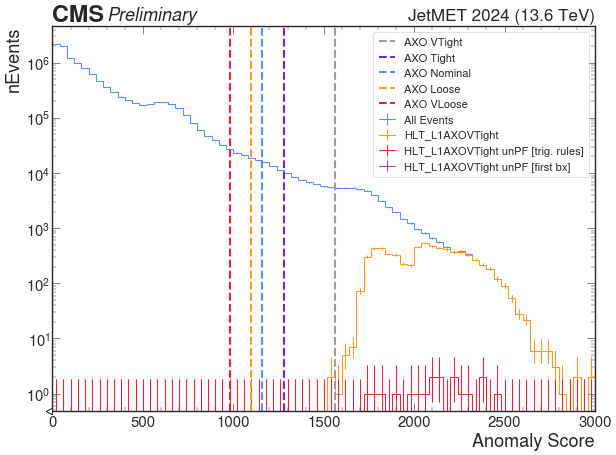

In [37]:
histpath = ['JetMET_2024D_wScores','hists']
trigger = 'HLT_L1AXOVTight'

fig, ax = plt.subplots(figsize=(14,10))
norm = 0
hep.cms.label('Preliminary', data=True, lumi=None, year='JetMET 2024', com=13.6)


hist_all = (getFromDict(hist_result, histpath+['anomaly_score']) * wgt)[:,hist.rebin(1)]
hist_all.plot(ax=ax, histtype='step', linestyle='-', density=norm, label='All Events')

hist_trig = (getFromDict(hist_result, histpath+['anomaly_score_HLT_L1AXOVTight']) * wgt)[:,hist.rebin(1)]
hist_trig.plot(ax=ax, histtype='step', linestyle='-', density=norm, label='HLT_L1AXOVTight')

hist_trig_unpf = (getFromDict(hist_result, histpath+['anomaly_score_unpf_HLT_L1AXOVTight']) * wgt)[:,hist.rebin(1
                                                                                                               )]
hist_trig_unpf.plot(ax=ax, histtype='step', linestyle='-', density=norm, label='HLT_L1AXOVTight unPF [trig. rules]')

hist_trig_unpf_firstbx = (getFromDict(hist_result, histpath+['anomaly_score_unpf_firstbx_HLT_L1AXOVTight']) * wgt)[:,hist.rebin(10)]
hist_trig_unpf_firstbx.plot(ax=ax, histtype='step', linestyle='-', density=norm, label='HLT_L1AXOVTight unPF [first bx]')

            
for th in thresholds.values():
    ax.axvline(x=th['score'], 
               label=th['name'], 
               color=ax._get_lines.get_next_color(),
               linestyle='--',
               linewidth=3,
)


# ax.set_ylim(1E-8, .1)
ax.set_xlim(0, 3000)
ax.set_yscale('log')
ax.set_ylabel(f'nEvents{" [A.U.]" if norm else ""}', loc='top')
ax.legend(frameon=True, fontsize=16);

## Event-Level Kinematic Plots

### L1 Objects

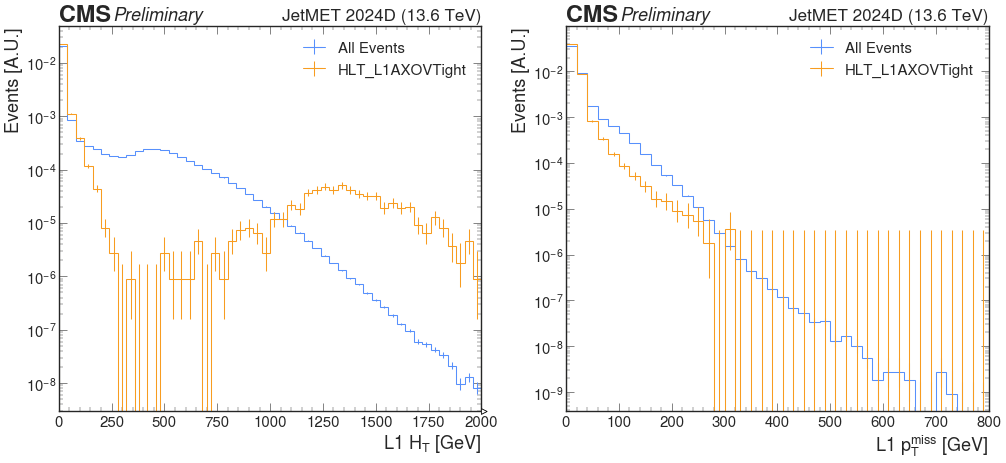

In [285]:
histpath = ['JetMET_2024D_wScores','hists']
trigger = 'HLT_L1AXOVTight'
fig, ax = plt.subplots(1, 2, figsize=(24, 10))

# HT
get_name = lambda suf=None: f'l1ht_{suf}' if suf else f'l1ht'
norm = True

hist_all = (getFromDict(hist_result, histpath+[get_name(None)]) * wgt)[:,hist.rebin(2)]
hist_trig = (getFromDict(hist_result, histpath+[get_name(trigger)]) * wgt)[:,hist.rebin(2)]
hist_all.plot(ax=ax[0], histtype='step', label='All Events', linestyle='-', density=norm)
hist_trig.plot(ax=ax[0], histtype='step', label='HLT_L1AXOVTight', linestyle='-', density=norm)

hep.cms.label('Preliminary', ax=ax[0], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
ax[0].set_xlim(0,2000)
ax[0].set_ylabel('Events [A.U.]', loc='top')
ax[0].set_xlabel(r'L1 $H_{T}$ [GeV]', loc='right')
ax[0].set_yscale('log')
ax[0].legend();

# MET
get_name = lambda suf=None: f'l1met_{suf}' if suf else f'l1met'
norm = True

hist_all = (getFromDict(hist_result, histpath+[get_name(None)]) * wgt)[:,hist.rebin(2)]
hist_trig = (getFromDict(hist_result, histpath+[get_name(trigger)]) * wgt)[:,hist.rebin(2)]
hist_all.plot(ax=ax[1], histtype='step', label='All Events', linestyle='-', density=norm)
hist_trig.plot(ax=ax[1], histtype='step', label='HLT_L1AXOVTight', linestyle='-', density=norm)

hep.cms.label('Preliminary', ax=ax[1], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
ax[1].set_xlim(0,800)
ax[1].set_ylabel('Events [A.U.]', loc='top')
ax[1].set_xlabel(r'L1 $p^{miss}_{T}$ [GeV]', loc='right')
ax[1].set_yscale('log')
ax[1].legend();

## Object-Level Kinematic Plots

### L1 Objects

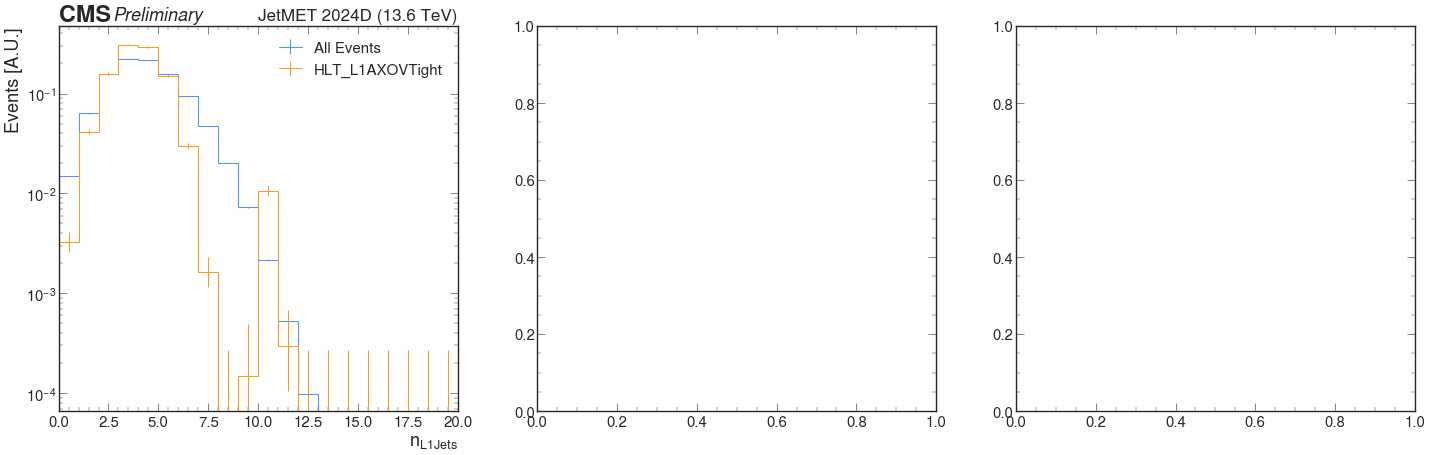

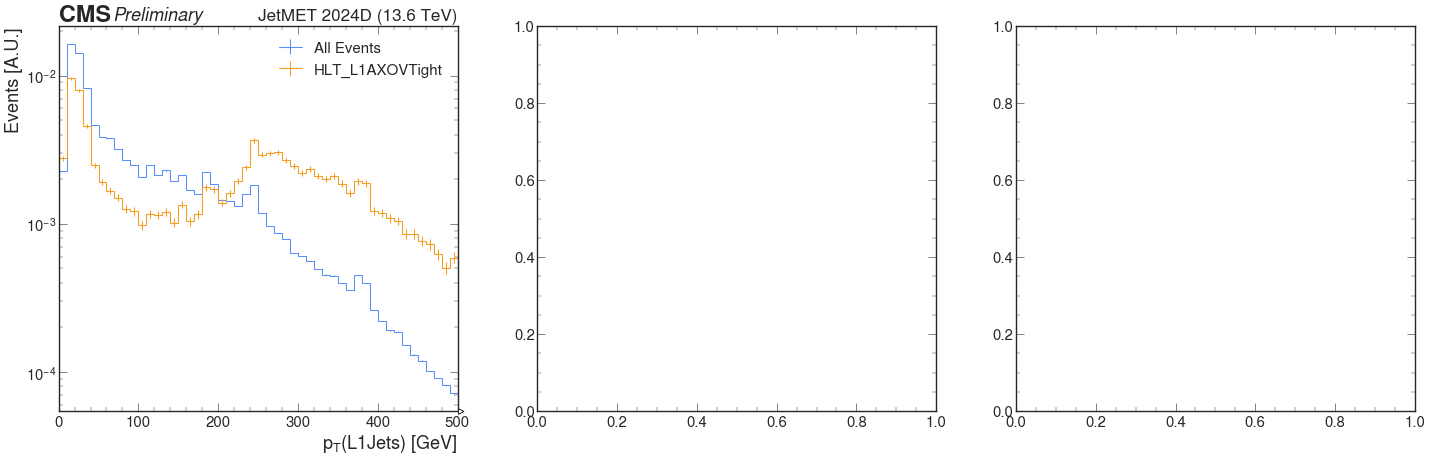

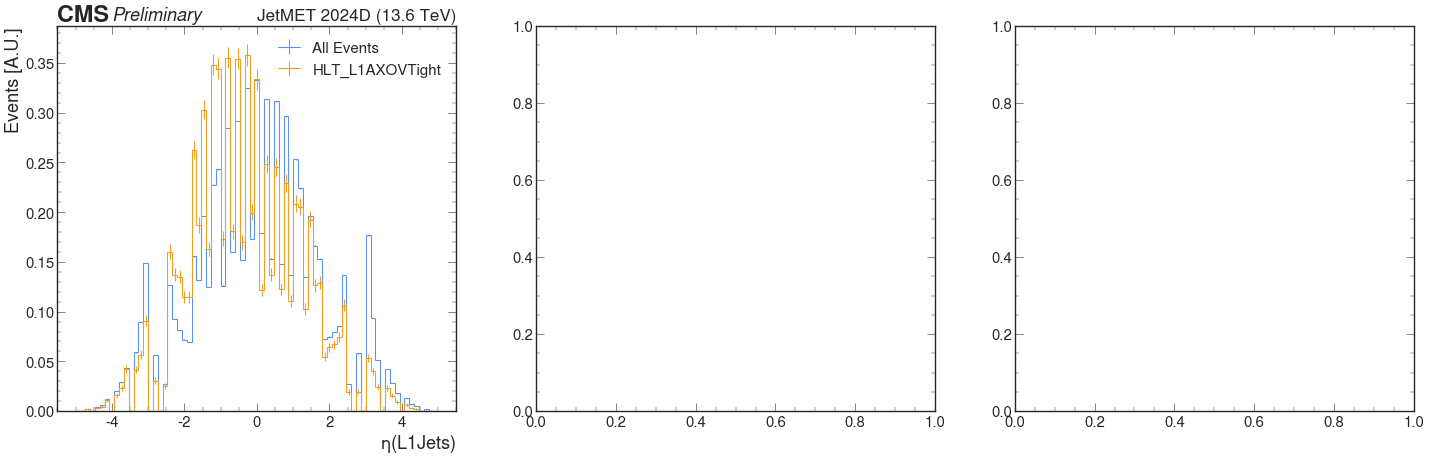

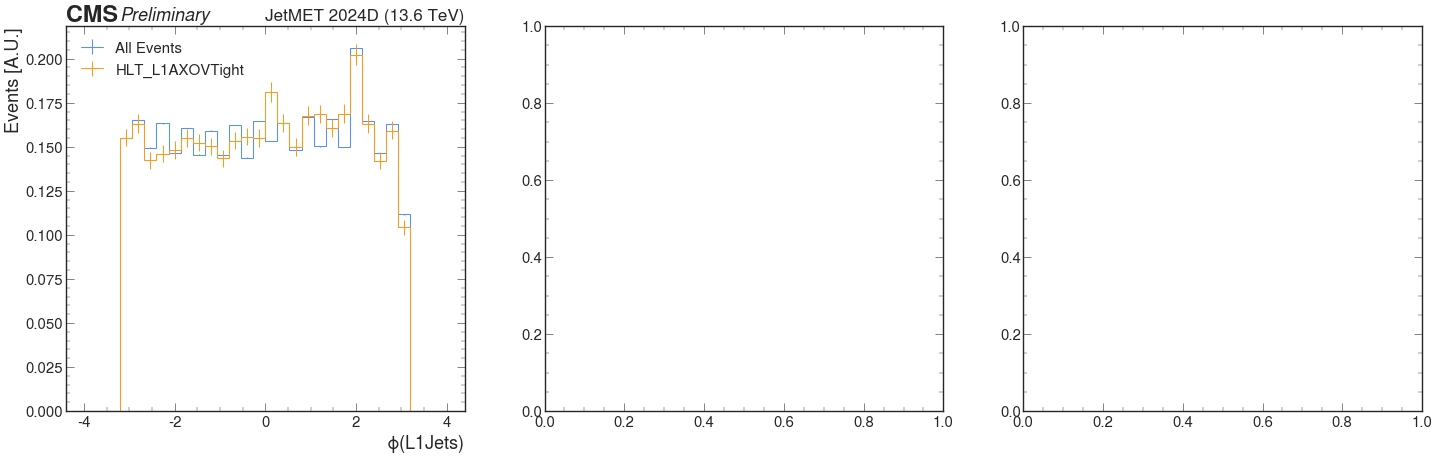

In [11]:
histpath = ['JetMET_2024D_wScores','hists']
trigger = 'HLT_L1AXOVTight'

# Multiplicity
get_name = lambda s, suf=None: f'n_{obj}_{suf}' if suf else f'n_{obj}'
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,20), (0,20), (0,20)]
norm = True
for i, obj in enumerate(['L1Jet', 'L1Mu', 'L1EG']):
    hist_all = (getFromDict(hist_result, histpath+[get_name(obj,None)]) * wgt)[:,hist.rebin(1)]
    hist_trig = (getFromDict(hist_result, histpath+[get_name(obj,trigger)]) * wgt)[:,hist.rebin(1)]
    hist_all.plot(ax=ax[i], histtype='step', label='All Events', linestyle='-', density=norm)
    hist_trig.plot(ax=ax[i], histtype='step', label='HLT_L1AXOVTight', linestyle='-', density=norm)

    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlim(*xrange[i])
    ax[i].set_xlabel(f'$n_{{{obj+"s"}}}$', loc='right')
    ax[i].set_ylabel('Events [A.U.]', loc='top')
    ax[i].set_yscale('log')
    ax[i].legend()


# Pt
get_name = lambda s, suf=None: f'pt_{obj}_{suf}' if suf else f'pt_{obj}'
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,500), (0,300), (0,300)]
for i, obj in enumerate(['L1Jet', 'L1Mu', 'L1EG']):
    hist_all = (getFromDict(hist_result, histpath+[get_name(obj,None)]) * wgt)[:,hist.rebin(4)]
    hist_trig = (getFromDict(hist_result, histpath+[get_name(obj,trigger)]) * wgt)[:,hist.rebin(4)]
    hist_all.plot(ax=ax[i], histtype='step', label='All Events', linestyle='-', density=norm)
    hist_trig.plot(ax=ax[i], histtype='step', label='HLT_L1AXOVTight', linestyle='-', density=norm)

    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlim(*xrange[i])
    ax[i].set_xlabel(f'$p_{{T}}({obj+"s"})$ [GeV]', loc='right')
    ax[i].set_ylabel('Events [A.U.]', loc='top')
    ax[i].set_yscale('log')
    ax[i].legend()


# Eta  
get_name = lambda s, suf=None: f'eta_{obj}_{suf}' if suf else f'eta_{obj}'
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
for i, obj in enumerate(['L1Jet', 'L1Mu', 'L1EG']):
    hist_all = (getFromDict(hist_result, histpath+[get_name(obj,None)]) * wgt)[:,hist.rebin(2)]
    hist_trig = (getFromDict(hist_result, histpath+[get_name(obj,trigger)]) * wgt)[:,hist.rebin(2)]
    hist_all.plot(ax=ax[i], histtype='step', label='All Events', linestyle='-', density=norm)
    hist_trig.plot(ax=ax[i], histtype='step', label='HLT_L1AXOVTight', linestyle='-', density=norm)

    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlabel(f'$\eta({obj+"s"})$', loc='right')
    ax[i].set_ylabel('Events [A.U.]', loc='top')
    # ax[i].set_yscale('log')
    ax[i].legend()


# Phi
get_name = lambda s, suf=None: f'phi_{obj}_{suf}' if suf else f'phi_{obj}'
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
for i, obj in enumerate(['L1Jet', 'L1Mu', 'L1EG']):
    hist_all = (getFromDict(hist_result, histpath+[get_name(obj,None)]) * wgt)
    hist_trig = (getFromDict(hist_result, histpath+[get_name(obj,trigger)]) * wgt)
    hist_all.plot(ax=ax[i], histtype='step', label='All Events', linestyle='-', density=norm)
    hist_trig.plot(ax=ax[i], histtype='step', label='HLT_L1AXOVTight', linestyle='-', density=norm)
    
    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlabel(f'$\phi({obj+"s"})$', loc='right')
    ax[i].set_ylabel('Events [A.U.]', loc='top')
    # ax[i].set_yscale('log')
    ax[i].legend()

### RECO Objects

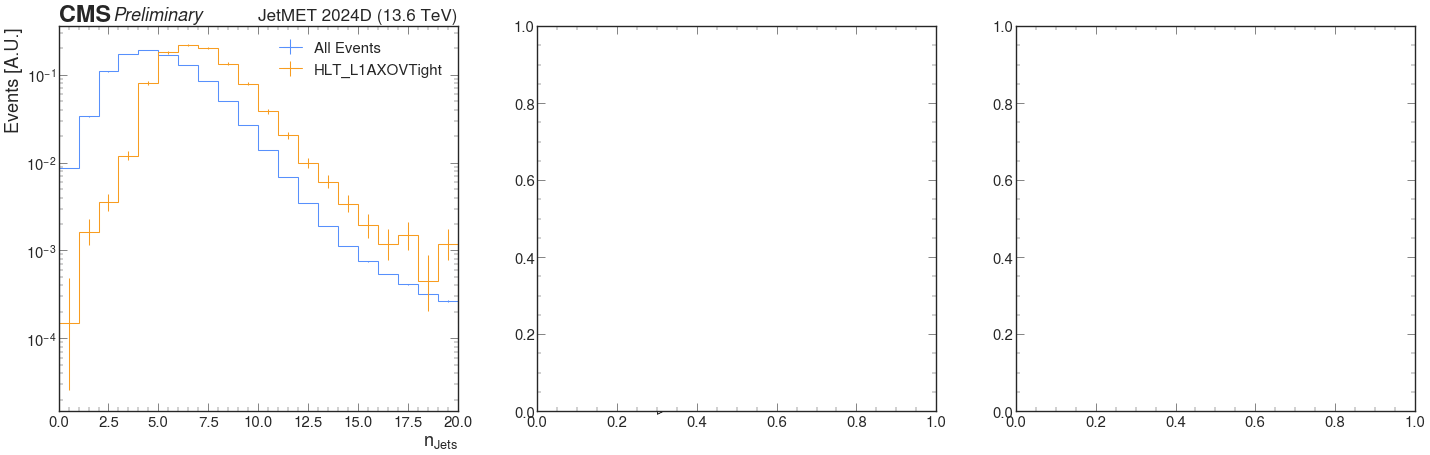

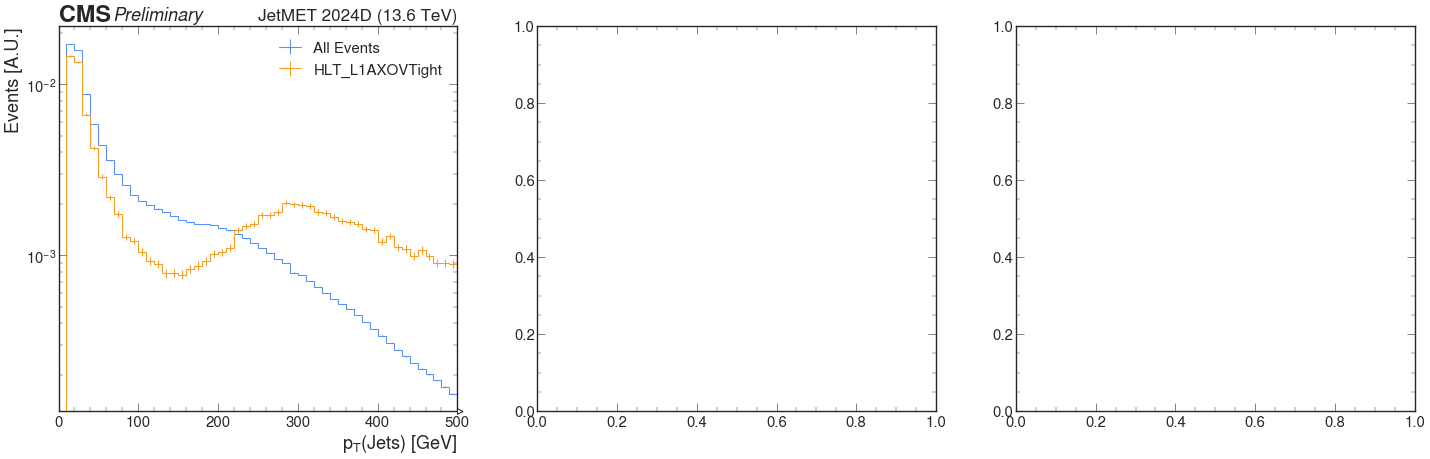

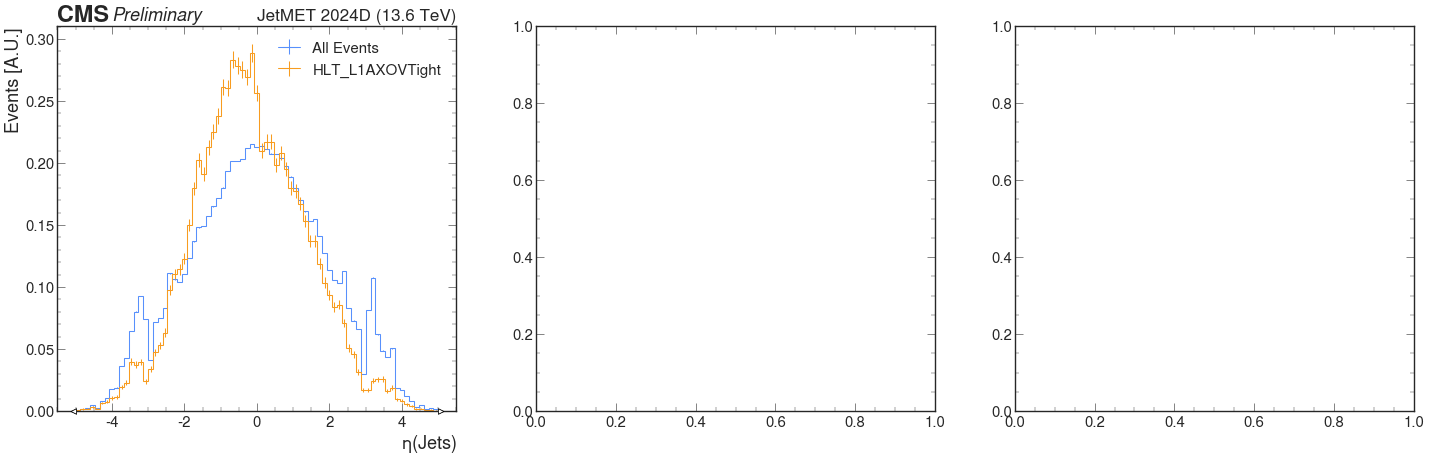

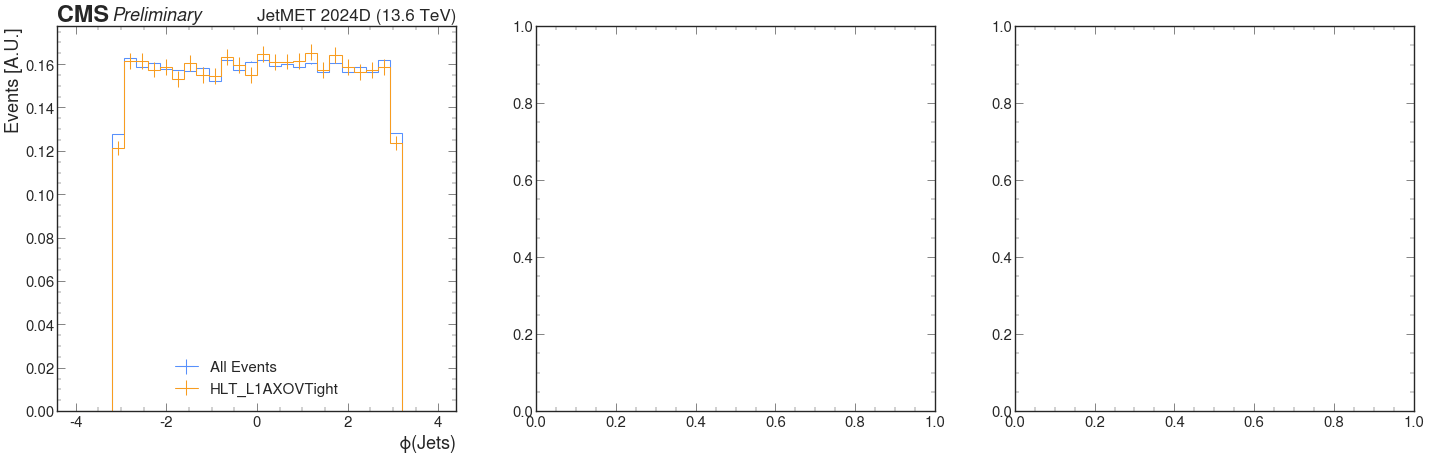

In [17]:
histpath = ['JetMET_2024D_wScores','hists']
trigger = 'HLT_L1AXOVTight'

# Multiplicity
get_name = lambda s, suf=None: f'n_{obj}_{suf}' if suf else f'n_{obj}'
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,20), (0,20), (0,20)]
norm = True
for i, obj in enumerate(['Jet', 'Muon', 'Electron']):
    hist_all = (getFromDict(hist_result, histpath+[get_name(obj,None)]) * wgt)[:,hist.rebin(1)]
    hist_trig = (getFromDict(hist_result, histpath+[get_name(obj,trigger)]) * wgt)[:,hist.rebin(1)]
    hist_all.plot(ax=ax[i], histtype='step', label='All Events', linestyle='-', density=norm)
    hist_trig.plot(ax=ax[i], histtype='step', label='HLT_L1AXOVTight', linestyle='-', density=norm)
    
    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlim(*xrange[i])
    ax[i].set_xlabel(f'$n_{{{obj+"s"}}}$', loc='right')
    ax[i].set_ylabel('Events [A.U.]', loc='top')
    ax[i].set_yscale('log')
    ax[i].legend()


# Pt
get_name = lambda s, suf=None: f'pt_{obj}_{suf}' if suf else f'pt_{obj}'
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,500), (0,500), (0,500)]
for i, obj in enumerate(['Jet', 'Muon', 'Electron']):
    hist_all = (getFromDict(hist_result, histpath+[get_name(obj,None)]) * wgt)[:,hist.rebin(4)]
    hist_trig = (getFromDict(hist_result, histpath+[get_name(obj,trigger)]) * wgt)[:,hist.rebin(4)]
    hist_all.plot(ax=ax[i], histtype='step', label='All Events', linestyle='-', density=norm)
    hist_trig.plot(ax=ax[i], histtype='step', label='HLT_L1AXOVTight', linestyle='-', density=norm)

    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlim(*xrange[i])
    ax[i].set_xlabel(f'$p_{{T}}({obj+"s"})$ [GeV]', loc='right')
    ax[i].set_ylabel('Events [A.U.]', loc='top')
    ax[i].set_yscale('log')
    ax[i].legend()


# Eta  
get_name = lambda s, suf=None: f'eta_{obj}_{suf}' if suf else f'eta_{obj}'
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
for i, obj in enumerate(['Jet', 'Muon', 'Electron']):
    hist_all = (getFromDict(hist_result, histpath+[get_name(obj,None)]) * wgt)[:,hist.rebin(2)]
    hist_trig = (getFromDict(hist_result, histpath+[get_name(obj,trigger)]) * wgt)[:,hist.rebin(2)]
    hist_all.plot(ax=ax[i], histtype='step', label='All Events', linestyle='-', density=norm)
    hist_trig.plot(ax=ax[i], histtype='step', label='HLT_L1AXOVTight', linestyle='-', density=norm)
    
    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlabel(f'$\eta({obj+"s"})$', loc='right')
    ax[i].set_ylabel('Events [A.U.]', loc='top')
    # ax[i].set_yscale('log')
    ax[i].legend()


# Phi
get_name = lambda s, suf=None: f'phi_{obj}_{suf}' if suf else f'phi_{obj}'
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
for i, obj in enumerate(['Jet', 'Muon', 'Electron']):
    hist_all = (getFromDict(hist_result, histpath+[get_name(obj,None)]) * wgt)[:,hist.rebin(1)]
    hist_trig = (getFromDict(hist_result, histpath+[get_name(obj,trigger)]) * wgt)[:,hist.rebin(1)]
    hist_all.plot(ax=ax[i], histtype='step', label='All Events', linestyle='-', density=norm)
    hist_trig.plot(ax=ax[i], histtype='step', label='HLT_L1AXOVTight', linestyle='-', density=norm)
    
    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlabel(f'$\phi({obj+"s"})$', loc='right')
    ax[i].set_ylabel('Events [A.U.]', loc='top')
    # ax[i].set_yscale('log')
    ax[i].legend()

## Di-Object Mass Plots

### RECO Objects

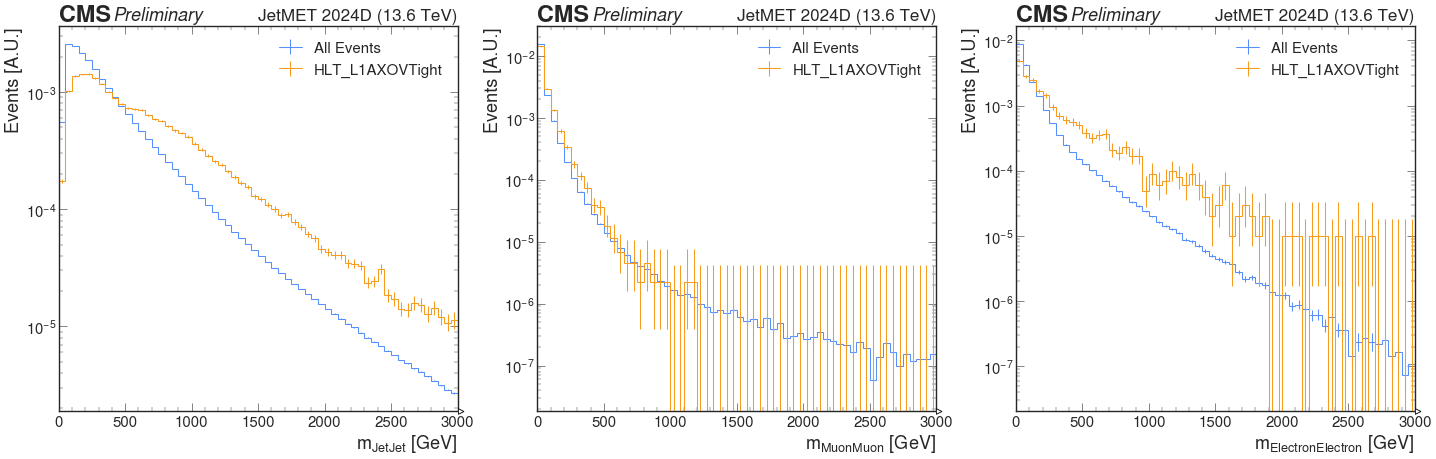

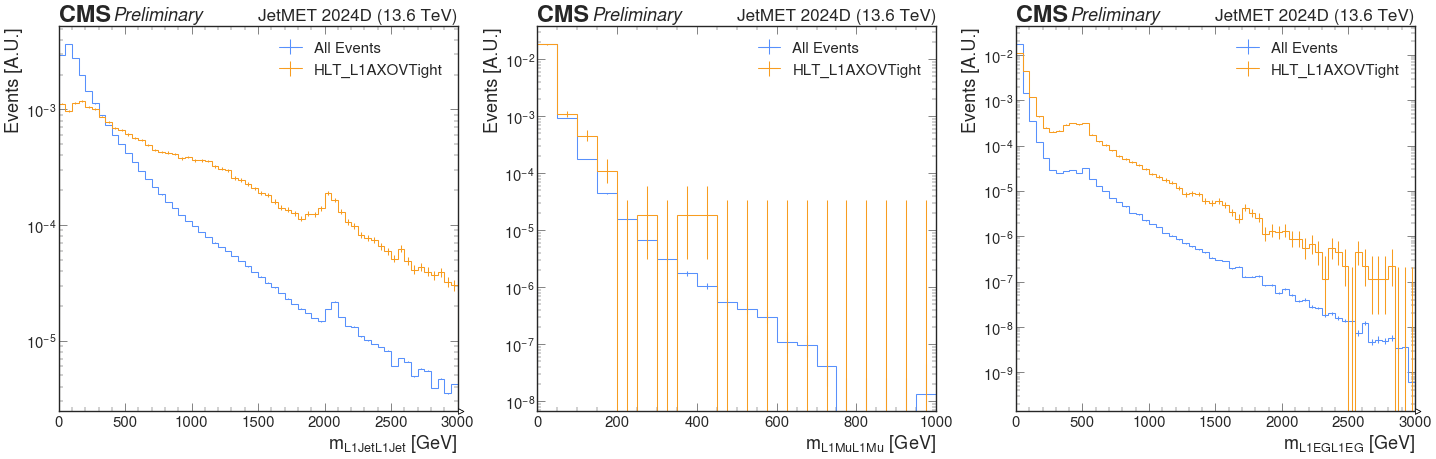

In [281]:
histpath = ['JetMET_2024D_wScores','hists']
trigger = 'HLT_L1AXOVTight'

# Multiplicity
get_name = lambda s, suf=None: f'm{obj}{obj}_{suf}' if suf else f'm{obj}{obj}'
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,3000), (0,3000), (0,3000)]
norm = True
for i, obj in enumerate(['Jet', 'Muon', 'Electron']):
    hist_all = (getFromDict(hist_result, histpath+[get_name(obj,None)]) * wgt)[:,hist.rebin(10)]
    hist_trig = (getFromDict(hist_result, histpath+[get_name(obj,trigger)]) * wgt)[:,hist.rebin(10)]
    hist_all.plot(ax=ax[i], histtype='step', label='All Events', linestyle='-', density=norm)
    hist_trig.plot(ax=ax[i], histtype='step', label='HLT_L1AXOVTight', linestyle='-', density=norm)
    
    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlim(*xrange[i])
    ax[i].set_xlabel(f'$m_{{{obj}{obj}}}$ [GeV]', loc='right')
    ax[i].set_ylabel('Events [A.U.]', loc='top')
    ax[i].set_yscale('log')
    ax[i].legend()
    
get_name = lambda s, suf=None: f'm{obj}{obj}_{suf}' if suf else f'm{obj}{obj}'
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,3000), (0,1000), (0,3000)]
norm = True
for i, obj in enumerate(['L1Jet', 'L1Mu', 'L1EG']):
    hist_all = (getFromDict(hist_result, histpath+[get_name(obj,None)]) * wgt)[:,hist.rebin(10)]
    hist_trig = (getFromDict(hist_result, histpath+[get_name(obj,trigger)]) * wgt)[:,hist.rebin(10)]
    hist_all.plot(ax=ax[i], histtype='step', label='All Events', linestyle='-', density=norm)
    hist_trig.plot(ax=ax[i], histtype='step', label='HLT_L1AXOVTight', linestyle='-', density=norm)
    if i==1: a = hist_trig
    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlim(*xrange[i])
    ax[i].set_xlabel(f'$m_{{{obj}{obj}}}$ [GeV]', loc='right')
    ax[i].set_ylabel('Events [A.U.]', loc='top')
    ax[i].set_yscale('log')
    ax[i].legend()

## 2D Correlation Plots

### L1 Objects

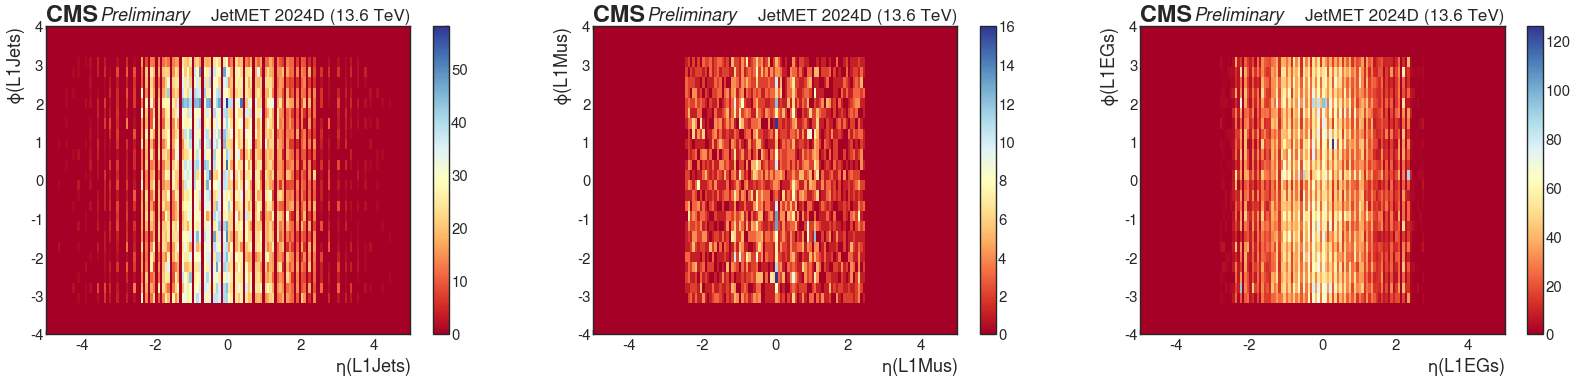

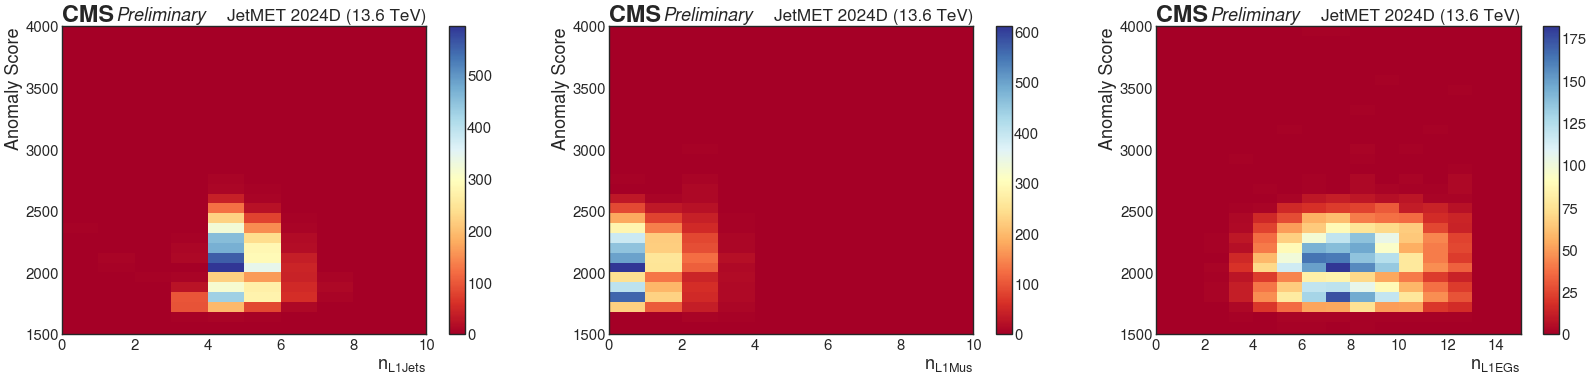

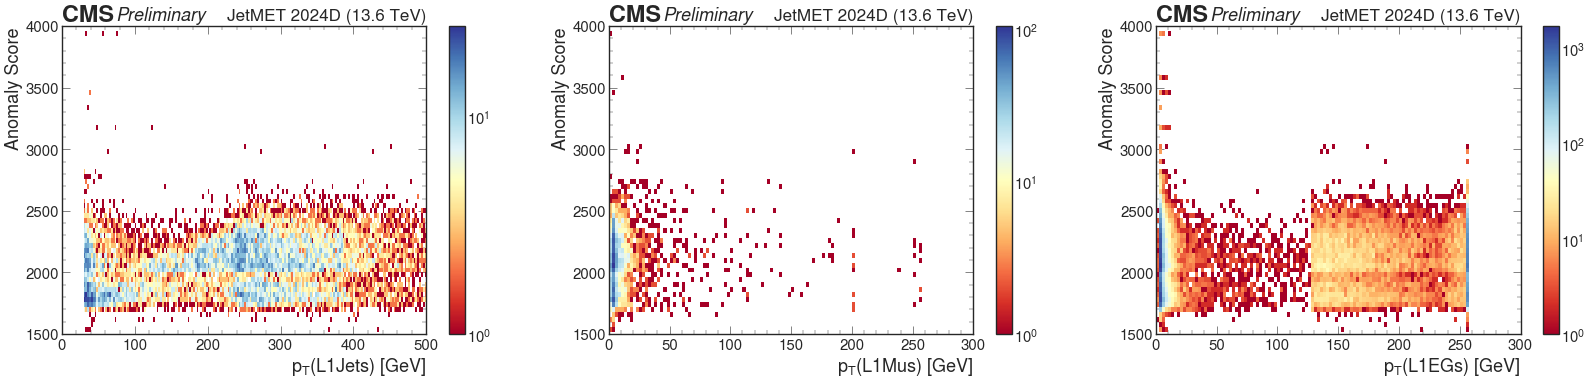

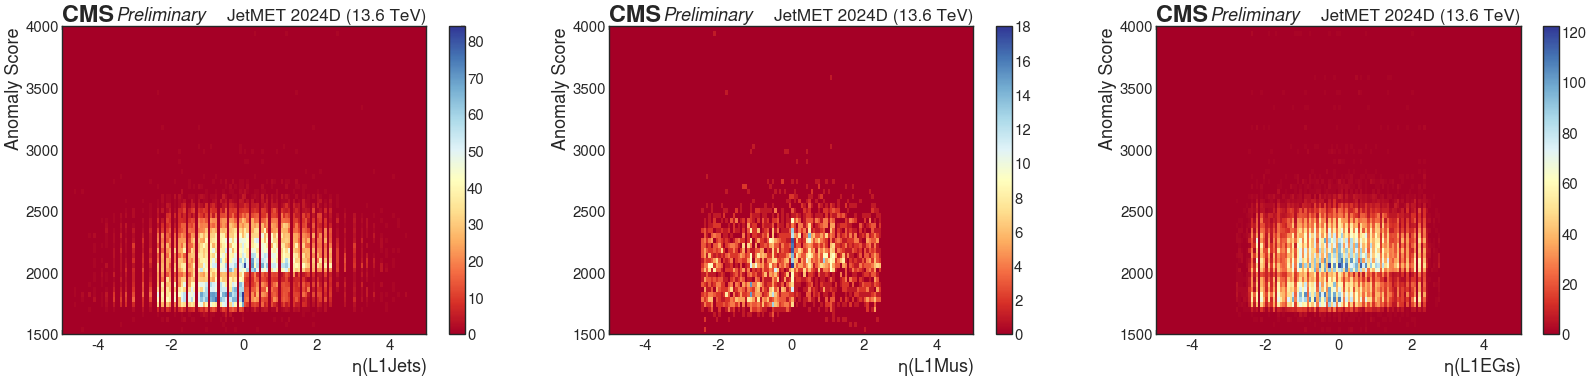

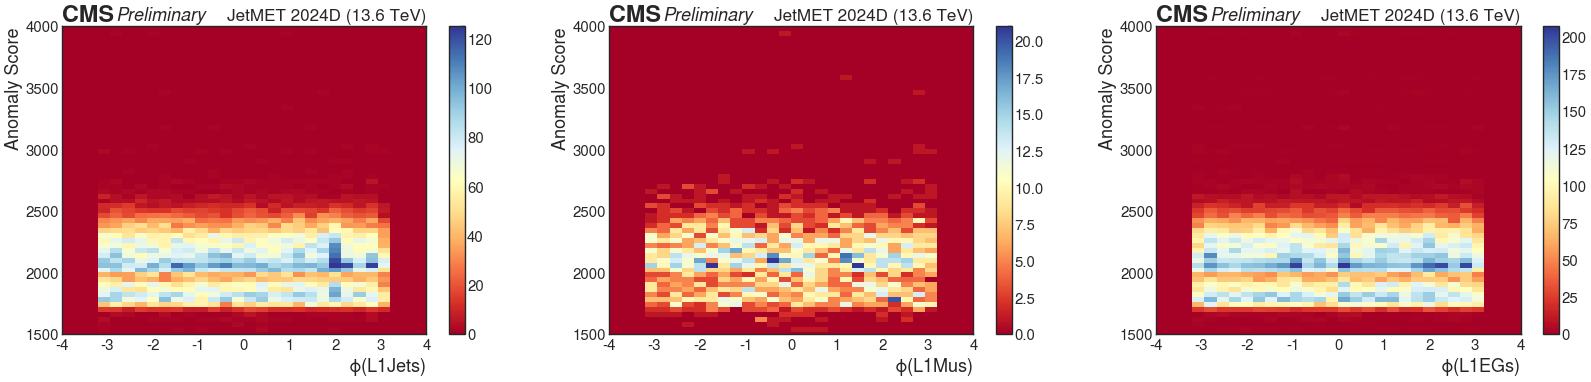

In [12]:
histpath = ['JetMET_2024D_wScores','hists']
trigger = 'HLT_L1AXOVTight'

# Eta vs. Phi
get_name = lambda s, suf=None: f'eta_phi_{obj}_{suf}' if suf else f'eta_phi_{obj}'
fig, ax = plt.subplots(1, 3, figsize=(40, 8))
# xrange = [(0,10), (0,10), (0,15)]
# yrange = [(1500,4000), (980,4000), (980,4000)]
norm = False
for i, obj in enumerate(['L1Jet', 'L1Mu', 'L1EG']):
    hist_all = (getFromDict(hist_result, histpath+[get_name(obj,None)]) * wgt)[:,hist.rebin(1),hist.rebin(1)]
    hist_trig = (getFromDict(hist_result, histpath+[get_name(obj,trigger)]) * wgt)[:,hist.rebin(1),hist.rebin(1)]
    
    w_all, x_all, y_all = hist_all.project('eta','phi').to_numpy()
    w_trig, x_trig, y_trig = hist_trig.project('eta','phi').to_numpy()

    # mesh = ax.pcolormesh(x_all, y_all, w_all.T, cmap="RdYlBu")
    mesh = ax[i].pcolormesh(x_trig, y_trig, w_trig.T, cmap="RdYlBu")

    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    # ax[i].set_xlim(*xrange[i])
    # ax[i].set_ylim(*yrange[i])
    ax[i].set_xlabel(f'$\eta({obj+"s"})$', loc='right')
    ax[i].set_ylabel(f'$\phi({obj+"s"})$', loc='top')
    fig.colorbar(mesh)

# Score vs. Multiplicity
get_name = lambda s, suf=None: f'anomaly_score_n_{obj}_{suf}' if suf else f'anomaly_score_n_{obj}'
fig, ax = plt.subplots(1, 3, figsize=(40, 8))
xrange = [(0,10), (0,10), (0,15)]
yrange = [(1500,4000), (1500,4000), (1500,4000)]
norm = False
for i, obj in enumerate(['L1Jet', 'L1Mu', 'L1EG']):
    hist_all = (getFromDict(hist_result, histpath+[get_name(obj,None)]) * wgt)[:,hist.rebin(2),hist.rebin(1)]
    hist_trig = (getFromDict(hist_result, histpath+[get_name(obj,trigger)]) * wgt)[:,hist.rebin(2),hist.rebin(1)]
    
    w_all, x_all, y_all = hist_all.project('mult','score').to_numpy()
    w_trig, x_trig, y_trig = hist_trig.project('mult','score').to_numpy()

    # mesh = ax.pcolormesh(x_all, y_all, w_all.T, cmap="RdYlBu")
    mesh = ax[i].pcolormesh(x_trig, y_trig, w_trig.T, cmap="RdYlBu")

    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlim(*xrange[i])
    ax[i].set_ylim(*yrange[i])
    ax[i].set_xlabel(f'$n_{{{obj+"s"}}}$', loc='right')
    ax[i].set_ylabel('Anomaly Score', loc='top')
    fig.colorbar(mesh)

#  Score vs. Pt
get_name = lambda s, suf=None: f'anomaly_score_pt_{obj}_{suf}' if suf else f'anomaly_score_pt_{obj}'
fig, ax = plt.subplots(1, 3, figsize=(40, 8))
xrange = [(0,500), (0,300), (0,300)]
yrange = [(1500,4000), (1500,4000), (1500,4000)]
norm = False
for i, obj in enumerate(['L1Jet', 'L1Mu', 'L1EG']):
    hist_all = (getFromDict(hist_result, histpath+[get_name(obj,None)]) * wgt)[:,hist.rebin(1),hist.rebin(1)]
    hist_trig = (getFromDict(hist_result, histpath+[get_name(obj,trigger)]) * wgt)[:,hist.rebin(1),hist.rebin(1)]
    
    w_all, x_all, y_all = hist_all.project('pt','score').to_numpy()
    w_trig, x_trig, y_trig = hist_trig.project('pt','score').to_numpy()

    # mesh = ax.pcolormesh(x_all, y_all, w_all.T, cmap="RdYlBu")
    mesh = ax[i].pcolormesh(x_trig, y_trig, w_trig.T, cmap="RdYlBu", norm=colors.LogNorm())

    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlim(*xrange[i])
    ax[i].set_ylim(*yrange[i])
    ax[i].set_xlabel(f'$p_{{T}}({obj+"s"})$ [GeV]', loc='right')
    ax[i].set_ylabel('Anomaly Score', loc='top')
    fig.colorbar(mesh)
    
#  Score vs. Eta
get_name = lambda s, suf=None: f'anomaly_score_eta_{obj}_{suf}' if suf else f'anomaly_score_eta_{obj}'
fig, ax = plt.subplots(1, 3, figsize=(40, 8))
# xrange = [(0,4000), (0,4000), (0,4000)]
yrange = [(1500,4000), (1500,4000), (1500,4000)]
norm = False
for i, obj in enumerate(['L1Jet', 'L1Mu', 'L1EG']):
    hist_all = (getFromDict(hist_result, histpath+[get_name(obj,None)]) * wgt)[:,hist.rebin(1),hist.rebin(1)]
    hist_trig = (getFromDict(hist_result, histpath+[get_name(obj,trigger)]) * wgt)[:,hist.rebin(1),hist.rebin(1)]
    
    w_all, x_all, y_all = hist_all.project('eta','score').to_numpy()
    w_trig, x_trig, y_trig = hist_trig.project('eta','score').to_numpy()

    # mesh = ax.pcolormesh(x_all, y_all, w_all.T, cmap="RdYlBu")
    mesh = ax[i].pcolormesh(x_trig, y_trig, w_trig.T, cmap="RdYlBu")

    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    # ax[i].set_xlim(*xrange[i])
    ax[i].set_ylim(*yrange[i])
    ax[i].set_xlabel(f'$\eta({obj+"s"})$', loc='right')
    ax[i].set_ylabel('Anomaly Score', loc='top')
    fig.colorbar(mesh)
    
#  Score vs. Phi
get_name = lambda s, suf=None: f'anomaly_score_phi_{obj}_{suf}' if suf else f'anomaly_score_phi_{obj}'
fig, ax = plt.subplots(1, 3, figsize=(40, 8))
# xrange = [(0,4000), (0,4000), (0,4000)]
yrange = [(1500,4000), (1500,4000), (1500,4000)]
norm = False
for i, obj in enumerate(['L1Jet', 'L1Mu', 'L1EG']):
    hist_all = (getFromDict(hist_result, histpath+[get_name(obj,None)]) * wgt)[:,hist.rebin(1),hist.rebin(1)]
    hist_trig = (getFromDict(hist_result, histpath+[get_name(obj,trigger)]) * wgt)[:,hist.rebin(1),hist.rebin(1)]
    
    w_all, x_all, y_all = hist_all.project('phi','score').to_numpy()
    w_trig, x_trig, y_trig = hist_trig.project('phi','score').to_numpy()

    # mesh = ax.pcolormesh(x_all, y_all, w_all.T, cmap="RdYlBu")
    mesh = ax[i].pcolormesh(x_trig, y_trig, w_trig.T, cmap="RdYlBu")

    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    # ax[i].set_xlim(*xrange[i])
    ax[i].set_ylim(*yrange[i])
    ax[i].set_xlabel(f'$\phi({obj+"s"})$', loc='right')
    ax[i].set_ylabel('Anomaly Score', loc='top')
    fig.colorbar(mesh)

### RECO Objects

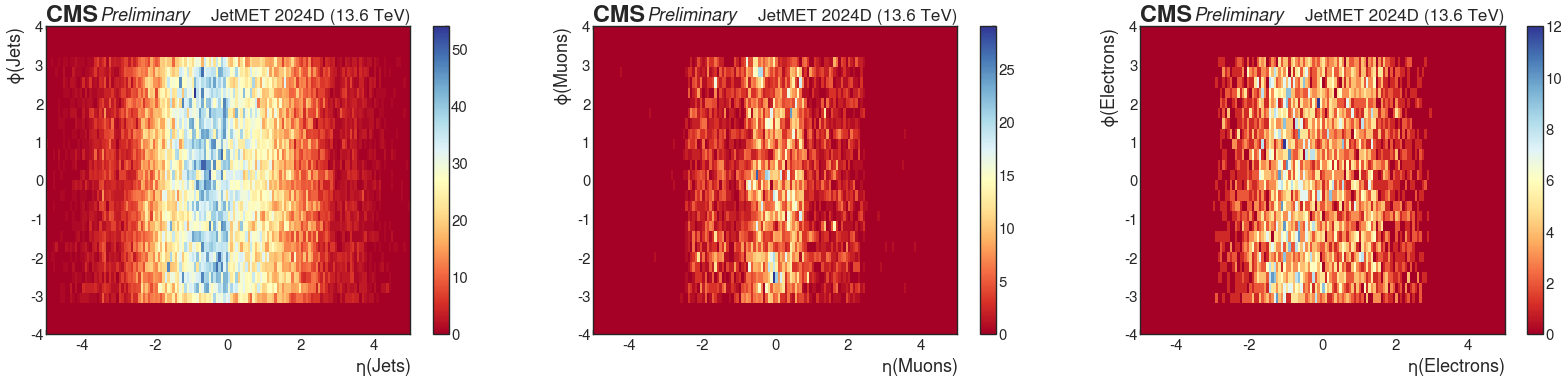

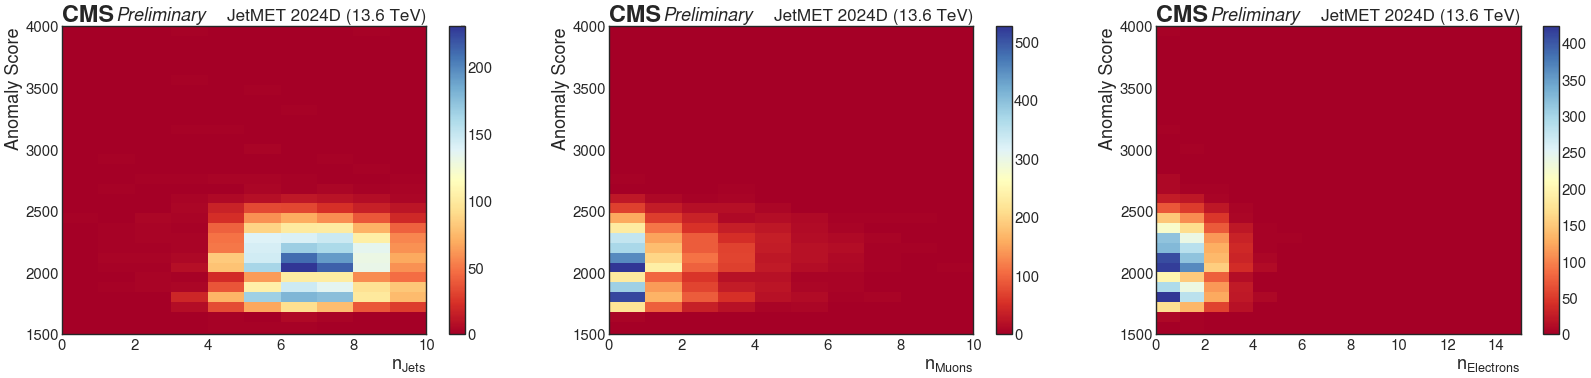

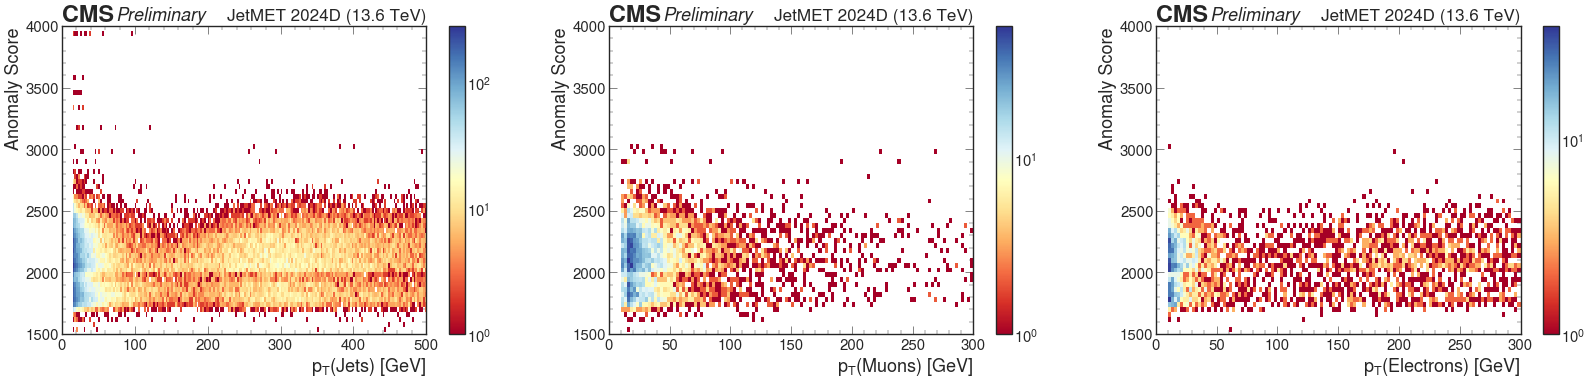

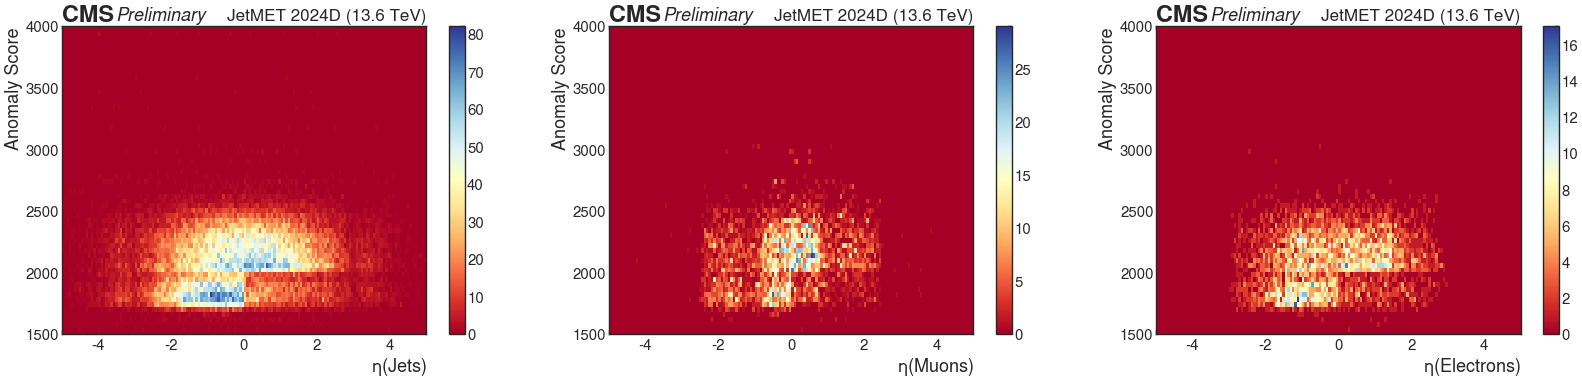

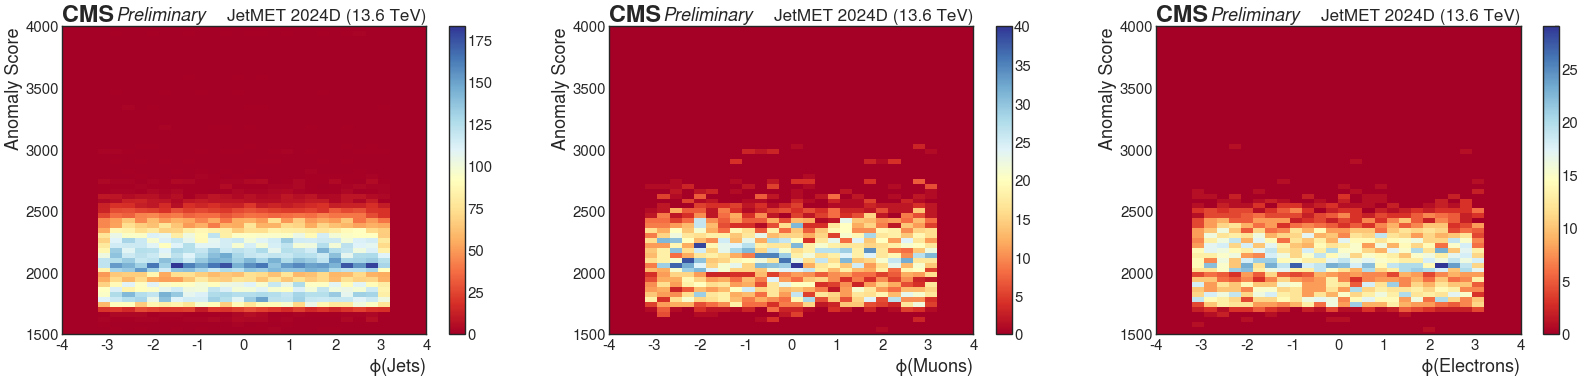

In [9]:
histpath = ['JetMET_2024D_wScores','hists']
trigger = 'HLT_L1AXOVTight'

# Eta vs. Phi
get_name = lambda s, suf=None: f'eta_phi_{obj}_{suf}' if suf else f'eta_phi_{obj}'
fig, ax = plt.subplots(1, 3, figsize=(40, 8))
# xrange = [(0,10), (0,10), (0,15)]
# yrange = [(1500,4000), (980,4000), (980,4000)]
norm = False
for i, obj in enumerate(['Jet', 'Muon', 'Electron']):
    hist_all = (getFromDict(hist_result, histpath+[get_name(obj,None)]) * wgt)[:,hist.rebin(1),hist.rebin(1)]
    hist_trig = (getFromDict(hist_result, histpath+[get_name(obj,trigger)]) * wgt)[:,hist.rebin(1),hist.rebin(1)]
    
    w_all, x_all, y_all = hist_all.project('eta','phi').to_numpy()
    w_trig, x_trig, y_trig = hist_trig.project('eta','phi').to_numpy()

    # mesh = ax.pcolormesh(x_all, y_all, w_all.T, cmap="RdYlBu")
    mesh = ax[i].pcolormesh(x_trig, y_trig, w_trig.T, cmap="RdYlBu")

    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    # ax[i].set_xlim(*xrange[i])
    # ax[i].set_ylim(*yrange[i])
    ax[i].set_xlabel(f'$\eta({obj+"s"})$', loc='right')
    ax[i].set_ylabel(f'$\phi({obj+"s"})$', loc='top')
    fig.colorbar(mesh)

# Score vs. Multiplicity
get_name = lambda s, suf=None: f'anomaly_score_n_{obj}_{suf}' if suf else f'anomaly_score_n_{obj}'
fig, ax = plt.subplots(1, 3, figsize=(40, 8))
xrange = [(0,10), (0,10), (0,15)]
yrange = [(1500,4000), (1500,4000), (1500,4000)]
norm = False
for i, obj in enumerate(['Jet', 'Muon', 'Electron']):
    hist_all = (getFromDict(hist_result, histpath+[get_name(obj,None)]) * wgt)[:,hist.rebin(2),hist.rebin(1)]
    hist_trig = (getFromDict(hist_result, histpath+[get_name(obj,trigger)]) * wgt)[:,hist.rebin(2),hist.rebin(1)]
    
    w_all, x_all, y_all = hist_all.project('mult','score').to_numpy()
    w_trig, x_trig, y_trig = hist_trig.project('mult','score').to_numpy()

    # mesh = ax.pcolormesh(x_all, y_all, w_all.T, cmap="RdYlBu")
    mesh = ax[i].pcolormesh(x_trig, y_trig, w_trig.T, cmap="RdYlBu")

    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlim(*xrange[i])
    ax[i].set_ylim(*yrange[i])
    ax[i].set_xlabel(f'$n_{{{obj+"s"}}}$', loc='right')
    ax[i].set_ylabel('Anomaly Score', loc='top')
    fig.colorbar(mesh)

#  Score vs. Pt
get_name = lambda s, suf=None: f'anomaly_score_pt_{obj}_{suf}' if suf else f'anomaly_score_pt_{obj}'
fig, ax = plt.subplots(1, 3, figsize=(40, 8))
xrange = [(0,500), (0,300), (0,300)]
yrange = [(1500,4000), (1500,4000), (1500,4000)]
norm = False
for i, obj in enumerate(['Jet', 'Muon', 'Electron']):
    hist_all = (getFromDict(hist_result, histpath+[get_name(obj,None)]) * wgt)[:,hist.rebin(1),hist.rebin(1)]
    hist_trig = (getFromDict(hist_result, histpath+[get_name(obj,trigger)]) * wgt)[:,hist.rebin(1),hist.rebin(1)]
    
    w_all, x_all, y_all = hist_all.project('pt','score').to_numpy()
    w_trig, x_trig, y_trig = hist_trig.project('pt','score').to_numpy()

    # mesh = ax.pcolormesh(x_all, y_all, w_all.T, cmap="RdYlBu")
    mesh = ax[i].pcolormesh(x_trig, y_trig, w_trig.T, cmap="RdYlBu", norm=colors.LogNorm())

    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlim(*xrange[i])
    ax[i].set_ylim(*yrange[i])
    ax[i].set_xlabel(f'$p_{{T}}({obj+"s"})$ [GeV]', loc='right')
    ax[i].set_ylabel('Anomaly Score', loc='top')
    fig.colorbar(mesh)
    
#  Score vs. Eta
get_name = lambda s, suf=None: f'anomaly_score_eta_{obj}_{suf}' if suf else f'anomaly_score_eta_{obj}'
fig, ax = plt.subplots(1, 3, figsize=(40, 8))
# xrange = [(0,4000), (0,4000), (0,4000)]
yrange = [(1500,4000), (1500,4000), (1500,4000)]
norm = False
for i, obj in enumerate(['Jet', 'Muon', 'Electron']):
    hist_all = (getFromDict(hist_result, histpath+[get_name(obj,None)]) * wgt)[:,hist.rebin(1),hist.rebin(1)]
    hist_trig = (getFromDict(hist_result, histpath+[get_name(obj,trigger)]) * wgt)[:,hist.rebin(1),hist.rebin(1)]
    
    w_all, x_all, y_all = hist_all.project('eta','score').to_numpy()
    w_trig, x_trig, y_trig = hist_trig.project('eta','score').to_numpy()

    # mesh = ax.pcolormesh(x_all, y_all, w_all.T, cmap="RdYlBu")
    mesh = ax[i].pcolormesh(x_trig, y_trig, w_trig.T, cmap="RdYlBu")

    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    # ax[i].set_xlim(*xrange[i])
    ax[i].set_ylim(*yrange[i])
    ax[i].set_xlabel(f'$\eta({obj+"s"})$', loc='right')
    ax[i].set_ylabel('Anomaly Score', loc='top')
    fig.colorbar(mesh)
    
#  Score vs. Phi
get_name = lambda s, suf=None: f'anomaly_score_phi_{obj}_{suf}' if suf else f'anomaly_score_phi_{obj}'
fig, ax = plt.subplots(1, 3, figsize=(40, 8))
# xrange = [(0,4000), (0,4000), (0,4000)]
yrange = [(1500,4000), (1500,4000), (1500,4000)]
norm = False
for i, obj in enumerate(['Jet', 'Muon', 'Electron']):
    hist_all = (getFromDict(hist_result, histpath+[get_name(obj,None)]) * wgt)[:,hist.rebin(1),hist.rebin(1)]
    hist_trig = (getFromDict(hist_result, histpath+[get_name(obj,trigger)]) * wgt)[:,hist.rebin(1),hist.rebin(1)]
    
    w_all, x_all, y_all = hist_all.project('phi','score').to_numpy()
    w_trig, x_trig, y_trig = hist_trig.project('phi','score').to_numpy()

    # mesh = ax.pcolormesh(x_all, y_all, w_all.T, cmap="RdYlBu")
    mesh = ax[i].pcolormesh(x_trig, y_trig, w_trig.T, cmap="RdYlBu")

    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    # ax[i].set_xlim(*xrange[i])
    ax[i].set_ylim(*yrange[i])
    ax[i].set_xlabel(f'$\phi({obj+"s"})$', loc='right')
    ax[i].set_ylabel('Anomaly Score', loc='top')
    fig.colorbar(mesh)

# Testing

In [ ]:
import uproot as ur

f = ur.open('root://xcache//store/user/nzipper/L1AD_Ntuples/Run3_2024_Data_Production-wScores/CRAB_UserFiles/crab_JetMET_Run2024D_PromptReco_v1_Run380349/240509_155442/0000/L1Nano_wScores_43.root:Events')
[k for k in f.keys() if (('L1_' not in k) and ('HLT_' not in k))]
